# Data Source: Bugzilla

In [1]:
import pdb
import bugzilla
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# tqdm extensions for pandas functions
tqdm.pandas()

## Get All Linked and Associated Bugs

In [3]:
# get the red hat dashboard names
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-assisted-installer"',
 '"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redhat-openshift-ocp-re

**NOTE** Since other notebooks also look at only one dashboard and job, we'll do the same. at the end we'll save the dataset for further analysis.

In [4]:
# bugs linked at timestamps up to this amount of time before today will be returned
max_age = '336h'

# ci details search url
url = 'https://search.ci.openshift.org/'

dashboard = '"redhat-openshift-ocp-release-4.2-informing"'

In [5]:
# get all linked bugs
associated_bugs = list()
all_linked_bugs = set()

# get all jobs in this dashboard
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")
job_names = response.json().keys()

for job in tqdm(job_names):
    # get all tests in this job
    response = requests.get(f"https://testgrid.k8s.io/{dashboard}/table?&show-stale-tests=&tab={job}")

    # params to send to openshift ci search for tests under this job
    args = {
        'type': 'bug+junit',
        'context': '-1',
        'name': job,
        'maxAge': max_age,
        # DO NOT REMOVE THESE KEYS. THIS HACK PREVENTS REQUESTS FROM TIMING OUT.
        # read more here - https://stackoverflow.com/a/63377265/9743348
        'ajax': 'true',
        'mobile': 'false',
    }

    for test in response.json().get('tests', []):
        testname = test['name'].split('.', maxsplit=1)[-1]

        # use test name as the search phrase
        args['search'] = testname.replace('[', '\[').replace(']', '\]')

        # search for linked and associated bugs for this test
        response = requests.post(url, data=args)
        soup = BeautifulSoup(response.content)

        # the "em" objects in soup have information that can tell us
        # whether or not this test had a linked bug for the given job name
        em_objects = soup.find_all('em')
        pct_affected = 0
        for em in em_objects:
            if 'Found' in em.text:
                pct_affected = float(em.text.split()[2][:-1])
                break

        # init to empty for this test result / reset to empty from previous test result
        test_bugs = []

        # if percent jobs affected is 0 then the linked bugs correspond to another job
        if pct_affected > 0:
            result_rows = soup.find('table').find('tbody').find_all('tr')
            for row in result_rows:
                column_values = row.find_all('td')

                # if there is only 1 column then the result is a junit, not bug
                if len(column_values) > 1:
                    # check the second column to make sure it is a bug and not junit details result
                    if column_values[1].text == 'bug':
                        test_bugs.append(column_values[0].text[1:])
                        all_linked_bugs.add(column_values[0].text[1:])

        associated_bugs.append((dashboard, job, test, test_bugs))

100%|██████████| 31/31 [19:51<00:00, 38.43s/it] 


In [16]:
linked_and_associated_bugs = pd.DataFrame(associated_bugs, columns=['dashboard', 'job', 'test_name', 'bug_ids'])
linked_and_associated_bugs.head()

,dashboard,job,test_name,bug_ids
0,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,"{'name': 'Overall', 'original-name': 'Overall'...",[]
1,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
2,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'Operator results.operator conditions...,[1936859]
3,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
4,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]


In [7]:
# todo: distribution of bugs across jobs

## Get Bugzilla Details

In [17]:
bzapi = bugzilla.Bugzilla("bugzilla.redhat.com")

In [18]:
samplebug = bzapi.getbug(1883345)
dir(samplebug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_aliases',
 '_rawdata',
 '_translate_dict',
 '_update_dict',
 'addcc',
 'addcomment',
 'alias',
 'assigned_to',
 'assigned_to_detail',
 'autorefresh',
 'blocks',
 'bugzilla',
 'cc',
 'cc_detail',
 'cf_clone_of',
 'cf_doc_type',
 'cf_environment',
 'cf_last_closed',
 'cf_release_notes',
 'cf_target_upstream_version',
 'classification',
 'close',
 'comments',
 'component',
 'components',
 'creation_time',
 'creator',
 'creator_detail',
 'deletecc',
 'depends_on',
 'description',
 'docs_contact',
 'external_bugs',
 'fixed_in',
 'flags',
 'get_attachment_ids',

In [19]:
# lets peek at some of the available bug metadata
samplebug._rawdata

{'priority': 'low',
 'cf_last_closed': <DateTime '20201105T12:46:56' at 0x7f1f7f50f5e0>,
 'creator': 'Cesar Wong',
 'blocks': [1883348],
 'assigned_to_detail': {'real_name': 'Cesar Wong',
  'email': 'cewong',
  'name': 'cewong',
  'id': 368980},
 'last_change_time': <DateTime '20201105T12:47:17' at 0x7f1f7f50fcd0>,
 'comments': [{'is_private': False,
   'count': 0,
   'creator': 'cewong',
   'time': <DateTime '20200928T20:47:20' at 0x7f1f7f50fbe0>,
   'bug_id': 1883345,
   'tags': [],
   'text': '+++ This bug was initially created as a clone of Bug #1883343 +++\n\nRe-enabling selected tests now that associated bugs have been fixed and are in the Red Hat OpenShift on IBM Cloud v4.3 builds\n\n[Feature:Prometheus][Conformance] Prometheus when installed on the cluster should provide ingress metrics\n[Conformance][Area:Networking][Feature:Router] The HAProxy router should enable openshift-monitoring to pull metrics\n[k8s.io] [sig-node] Pods Extended [k8s.io] Pod Container Status should neve

In [20]:
samplebug.bugzilla

In [21]:
samplebug._aliases

[('summary', 'short_desc'),
 ('description', 'comment'),
 ('platform', 'rep_platform'),
 ('severity', 'bug_severity'),
 ('status', 'bug_status'),
 ('id', 'bug_id'),
 ('blocks', 'blockedby'),
 ('blocks', 'blocked'),
 ('depends_on', 'dependson'),
 ('creator', 'reporter'),
 ('url', 'bug_file_loc'),
 ('dupe_of', 'dupe_id'),
 ('dupe_of', 'dup_id'),
 ('comments', 'longdescs'),
 ('creation_time', 'opendate'),
 ('creation_time', 'creation_ts'),
 ('whiteboard', 'status_whiteboard'),
 ('last_change_time', 'delta_ts'),
 ('fixed_in', 'cf_fixed_in'),
 ('qa_whiteboard', 'cf_qa_whiteboard'),
 ('devel_whiteboard', 'cf_devel_whiteboard'),
 ('internal_whiteboard', 'cf_internal_whiteboard'),
 ('flags', 'flag_types')]

**NOTE** `_rawdata` seems redundant, the information is already captured in other fields. And `bugzilla` attribute is depracated / old representation.

In [22]:
list(vars(samplebug).keys()).remove('bugzilla')

In [23]:
# get all the available fields, except the depracated and duplicate ones
bug_details_to_get = list(vars(samplebug).keys())
bug_details_to_get.remove('_rawdata')
bug_details_to_get.remove('bugzilla')
bug_details_to_get.remove('_aliases')

# these two keys are msissing for a lot of bugs
bug_details_to_get.remove('qa_contact_detail')
bug_details_to_get.remove('cf_last_closed')
bug_details_to_get.remove('cf_clone_of')

bug_details_to_get

['autorefresh',
 'priority',
 'creator',
 'blocks',
 'assigned_to_detail',
 'last_change_time',
 'comments',
 'is_cc_accessible',
 'keywords',
 'creator_detail',
 'cc',
 'see_also',
 'groups',
 'assigned_to',
 'url',
 'qa_contact',
 'creation_time',
 'whiteboard',
 'id',
 'depends_on',
 'cf_target_upstream_version',
 'docs_contact',
 'description',
 'resolution',
 'classification',
 'cf_doc_type',
 'alias',
 'op_sys',
 'target_release',
 'status',
 'cc_detail',
 'external_bugs',
 'summary',
 'is_open',
 'platform',
 'severity',
 'cf_environment',
 'flags',
 'version',
 'tags',
 'component',
 'sub_components',
 'is_creator_accessible',
 'cf_release_notes',
 'product',
 'target_milestone',
 'is_confirmed',
 'components',
 'versions',
 'sub_component',
 'fixed_in',
 'weburl']

In [24]:
# create a df containing details of all linked and associated bugs
bugs_df = pd.DataFrame(columns=['bug_id'] + bug_details_to_get, index=range(len(all_linked_bugs)))
bugs_df = bugs_df.assign(bug_id=all_linked_bugs)
bugs_df.head()

,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,is_creator_accessible,cf_release_notes,product,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl
0,1890130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1846669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1874873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1822324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
def fill_bug_details(bug_row):
    global bzapi
    
    try:
        bug = bzapi.getbug(bug_row.bug_id)
    except Exception:
        return bug_row
    
    for detail in bug_row.index:
        try:
            bug_row[detail] = getattr(bug, detail)
        except AttributeError:
            print(detail)

    return bug_row

bugs_df.progress_apply(fill_bug_details, axis=1)
bugs_df

100%|██████████| 2858/2858 [31:23<00:00,  1.52it/s]  


,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,is_creator_accessible,cf_release_notes,product,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl
0,1890130,False,urgent,Casey Callendrello,"[1890297, 1893809]","{'real_name': 'Casey Callendrello', 'email': '...",20210224T15:27:46,"[{'is_private': False, 'count': 0, 'creator': ...",True,[Upgrades],...,True,,OpenShift Container Platform,---,True,[Networking],[4.7],openshift-sdn,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
1,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1846669,False,medium,Olimp Bockowski,[1846671],"{'real_name': 'Mike Dame', 'email': 'mdame', '...",20201027T16:07:23,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[kube-scheduler],[4.4],,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
3,1874873,False,unspecified,Christian Huffman,[1879109],"{'real_name': 'Christian Huffman', 'email': 'c...",20200921T17:42:21,"[{'is_private': False, 'count': 3, 'creator': ...",True,"[UpcomingSprint, Upgrades]",...,True,,OpenShift Container Platform,---,True,[Storage],[4.3.z],,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
4,1822324,False,unspecified,Abu Kashem,[],"{'real_name': 'Vikram Goyal', 'email': 'vigoya...",20201102T01:30:16,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Documentation],[4.3.0],,,https://bugzilla.redhat.com/show_bug.cgi?id=18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,1928618,False,medium,jmencak,[],"{'real_name': '', 'email': 'jmencak', 'name': ...",20210218T10:27:53,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Node Tuning Operator],[4.7],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
2854,1946839,False,high,Neeraj,[],"{'real_name': 'Maciej Szulik', 'email': 'maszu...",20210414T14:04:11,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,Cause: \r\nDuring mirroring we create an autho...,OpenShift Container Platform,---,True,[oc],[4.6],,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
2855,1925210,False,unspecified,Jakub Hrozek,[],"{'real_name': 'Surya Seetharaman', 'email': 's...",20210218T13:44:01,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Networking],[4.7],openshift-sdn,,https://bugzilla.redhat.com/show_bug.cgi?id=19...
2856,1941726,False,unspecified,Elana Hashman,[],"{'real_name': 'Harshal Patil', 'email': 'harpa...",20210409T11:21:34,"[{'is_private': False, 'count': 0, 'creator': ...",True,[],...,True,,OpenShift Container Platform,---,True,[Node],[4.8],Kubelet,,https://bugzilla.redhat.com/show_bug.cgi?id=19...


In [26]:
for i in bugs_df.columns:
    print(i)

bug_id
autorefresh
priority
creator
blocks
assigned_to_detail
last_change_time
comments
is_cc_accessible
keywords
creator_detail
cc
see_also
groups
assigned_to
url
qa_contact
creation_time
whiteboard
id
depends_on
cf_target_upstream_version
docs_contact
description
resolution
classification
cf_doc_type
alias
op_sys
target_release
status
cc_detail
external_bugs
summary
is_open
platform
severity
cf_environment
flags
version
tags
component
sub_components
is_creator_accessible
cf_release_notes
product
target_milestone
is_confirmed
components
versions
sub_component
fixed_in
weburl


## Bug fields

### summary

In [27]:
bugs_df.summary.head()

0               multitenant mode consistently fails CI
1                                                  NaN
2    misleading  scheduler.spec.defaultNodeSelector...
3    [4.5] Storage operator stops reconciling when ...
4                     Fix openshift doc on default SCC
Name: summary, dtype: object

In [29]:
bugs_df.summary[0]

'multitenant mode consistently fails CI'

The bug `summary` is a short sentence which succinctly describes what the bug is about.

### is_open

In [30]:
bugs_df.is_open.head()

0    False
1      NaN
2    False
3    False
4    False
Name: is_open, dtype: object

The bug `is_open` field returns a boolean value indicating if the bug is currently open or not

### platform

In [31]:
bugs_df.platform.head()

0    Unspecified
1            NaN
2            All
3    Unspecified
4    Unspecified
Name: platform, dtype: object

`platform` field indicates the hardware platform the bug was observed on.

In [32]:
platforms = bugs_df.platform.unique()
print(platforms)

['Unspecified' nan 'All' 'x86_64' 's390x' 'ppc64le' 'ppc64']


In [33]:
platforms_count = []
for i in range(len(platforms)):
    platforms_count.append((bugs_df.platform == platforms[i]).sum())
platforms_count

[2310, 0, 119, 236, 34, 22, 1]

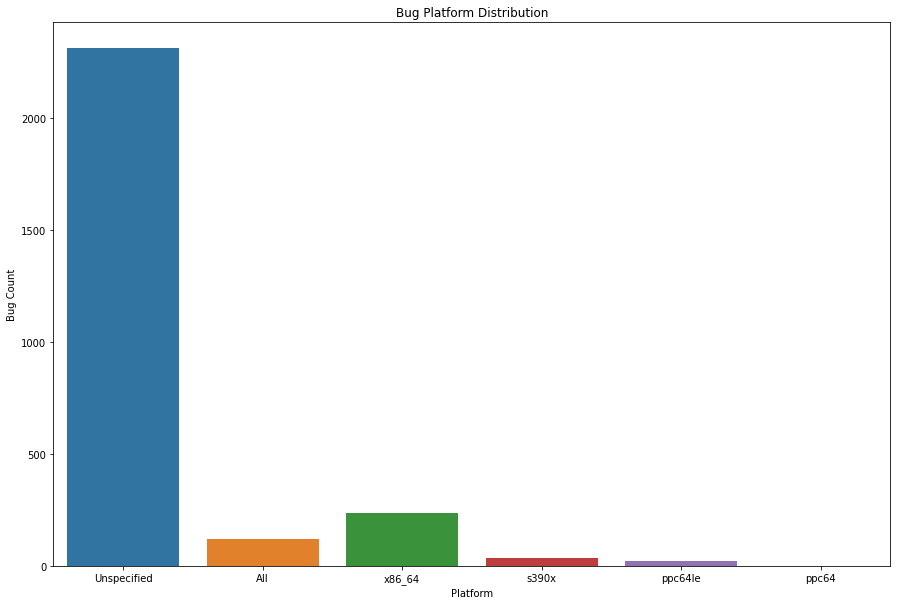

In [34]:
plt.figure(figsize = (15,10))
sns.barplot(platforms, platforms_count)
plt.xlabel("Platform")
plt.ylabel("Bug Count")
plt.title("Bug Platform Distribution")
plt.show()

### severity

In [35]:
bugs_df.severity.head()

0         urgent
1            NaN
2         medium
3           high
4    unspecified
Name: severity, dtype: object

The `severity` field categorzies the severity level of each bug. Let's see the different severity levels defined.

In [36]:
severity = bugs_df.severity.unique()
print(severity)

['urgent' nan 'medium' 'high' 'unspecified' 'low']


In [37]:
severity_count = []
for i in range(len(severity)):
    severity_count.append((bugs_df.severity == severity[i]).sum())
severity_count

[335, 0, 933, 970, 166, 318]

Let's plot a simple graph to visualize the distribution of bug severities

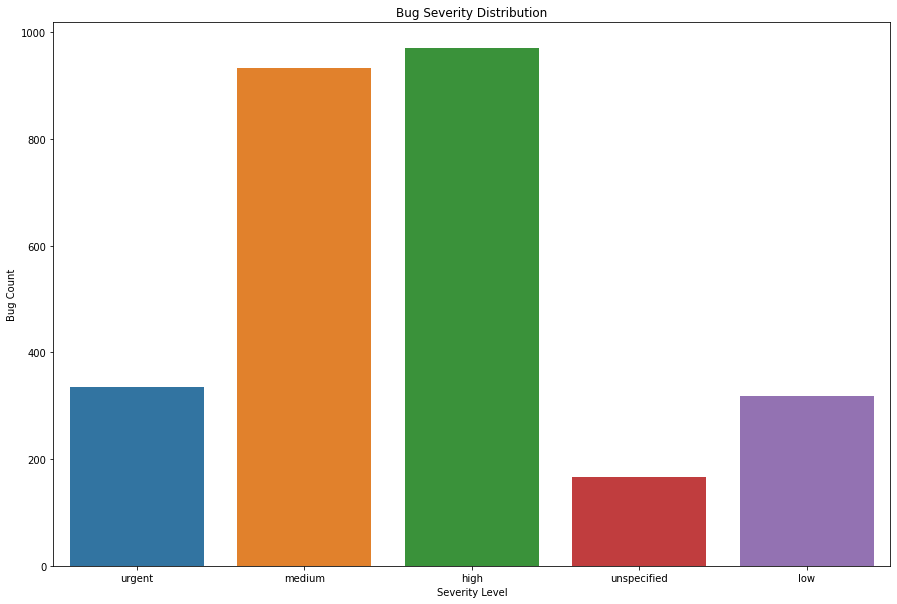

In [38]:
plt.figure(figsize = (15,10))
sns.barplot(severity, severity_count)
plt.xlabel("Severity Level")
plt.ylabel("Bug Count")
plt.title("Bug Severity Distribution")
plt.show()

### cf_environment

In [39]:
bugs_df.cf_environment.head()

0       
1    NaN
2       
3       
4       
Name: cf_environment, dtype: object

In [40]:
cf_env = bugs_df.cf_environment.unique()
len(cf_env)

144

In [41]:
cf_env[1]

nan

Not too sure what `cf_environment` is supposed to return

### flags

In [42]:
bugs_df['flags'][:10]

0     []
1    NaN
2     []
3     []
4     []
5     []
6     []
7     []
8     []
9     []
Name: flags, dtype: object

In [43]:
bugs_df['flags'][6]

[]

The `flags` field seems to return empty for most bugs. For thos bugs which have this field set, it seems to have redundant information which are already available in other bug fields so we can probably ignore this field.

### version

In [44]:
bugs_df.version.head()

0      4.7
1      NaN
2      4.4
3    4.3.z
4    4.3.0
Name: version, dtype: object

In [45]:
versions = bugs_df.version.unique()
versions

array(['4.7', nan, '4.4', '4.3.z', '4.3.0', '4.5', '4.6', '4.8', '4.6.z',
       '4.2.z', '2.3.0', '8.2', '4.2.0', 'rhacm-2.2.z', '1.3.0', '2.4.0',
       '2.5.0', '16.1 (Train)', 'FDB 18.11', '2.4.1', 'FDP 20.E',
       'unspecified', 'rhacm-1.0.z', 'RHEL 8.0'], dtype=object)

In [46]:
version_count = []
for i in range(len(versions)):
    version_count.append((bugs_df.version == versions[i]).sum())
version_count

[586,
 0,
 235,
 79,
 42,
 612,
 814,
 182,
 110,
 17,
 1,
 2,
 21,
 1,
 3,
 2,
 6,
 1,
 1,
 1,
 1,
 3,
 1,
 1]

The `version` field indicates the version of the software the bug was found in. Let's plot a simple graph to visualize the distribution of bugs across different software versions.

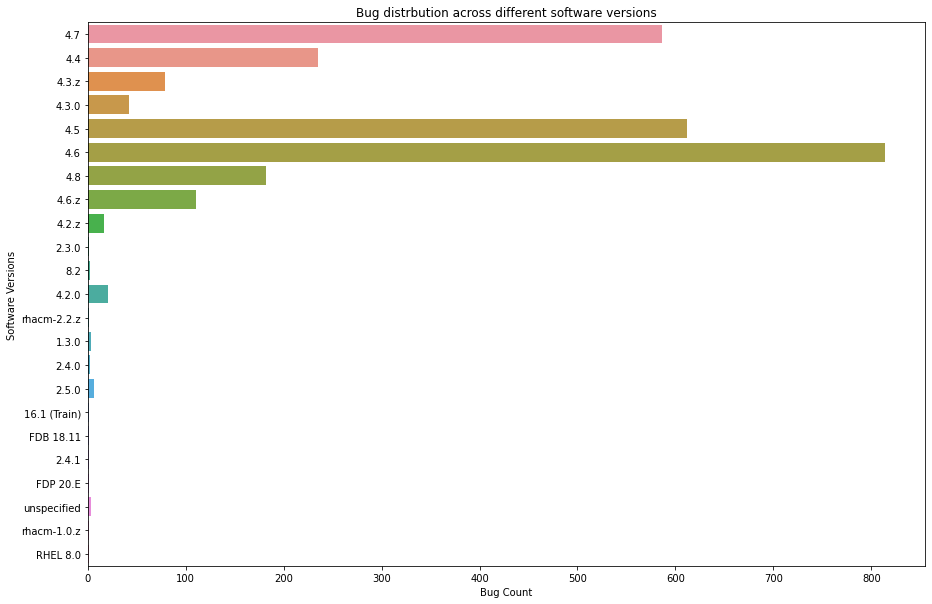

In [47]:
plt.figure(figsize = (15,10))
sns.barplot(version_count, versions)
plt.xlabel("Bug Count")
plt.ylabel("Software Versions")
plt.title("Bug distrbution across different software versions")
plt.show()

### tags

In [48]:
bugs_df.tags.head()

0     []
1    NaN
2     []
3     []
4     []
Name: tags, dtype: object

The `tags` field seems to be empty for most bugs so we can probably ignore this field.

### component

In [49]:
bugs_df.component.head()

0        Networking
1               NaN
2    kube-scheduler
3           Storage
4     Documentation
Name: component, dtype: object

In [50]:
components = bugs_df.component.unique()
components

array(['Networking', nan, 'kube-scheduler', 'Storage', 'Documentation',
       'Logging', 'openshift-apiserver', 'DNS', 'Installer',
       'kube-apiserver', 'Etcd', 'OLM', 'assisted-installer',
       'sandboxed-containers', 'Node', 'Operator SDK',
       'Windows Containers', 'Build', 'Cluster Version Operator', 'RHCOS',
       'Machine Config Operator', 'Special Resource Operator',
       'Image Registry', 'Cloud Compute', 'Node Tuning Operator',
       'Routing', 'csi-driver', 'Management Console', 'Monitoring',
       'Cloud Credential Operator', 'service-ca', 'Insights Operator',
       'openshift-controller-manager', 'Metering Operator',
       'oauth-apiserver', 'ibm-roks-toolkit',
       'Node Feature Discovery Operator', 'Etcd Operator', 'Unknown',
       'config-operator', 'CNF Platform Validation',
       'kube-controller-manager', 'apiserver-auth', 'ImageStreams', 'oc',
       'Console Kubevirt Plugin', 'Virtualization', 'Multi-Arch',
       'File Integrity Operator', 'Mig

In [51]:
component_count = []
for i in range(len(components)):
    component_count.append((bugs_df.component == components[i]).sum())

Bugs are categorised into Product and Component. Components are second-level categories and the `component` field indicates which component is affected by the bug.

### sub_component

In [52]:
bugs_df.sub_component.head()

0    openshift-sdn
1              NaN
2                 
3                 
4                 
Name: sub_component, dtype: object

In [53]:
sub_component = bugs_df.sub_component.unique()
len(sub_component)

49

In [54]:
sub_component

array(['openshift-sdn', nan, '', 'ovn-kubernetes', 'OpenShift on RHV',
       'OLM', 'assisted-ui', 'Kubelet', 'assisted-service', 'Operators',
       'Other Providers', 'Local Storage Operator', 'openshift-installer',
       'Autoscaler (HPA, VPA)', 'runtime-cfg', 'kuryr',
       'controller-manager', 'CRI-O', 'oVirt Provider', 'mDNS',
       'Kubernetes', 'OperatorHub', 'discovery-agent', 'Storage',
       'OpenStack Provider', 'oVirt CSI Driver',
       'OpenShift on Bare Metal IPI', 'openshift-ansible', 'multus',
       'Networking Misc', 'KubeVirt Provider', 'OpenShift on OpenStack',
       'SR-IOV', 'Installer', 'stand-alone', 'OpenStack CSI Drivers',
       'BareMetal Provider', 'Kubernetes External Components',
       'cluster-baremetal-operator', 'operand', 'other',
       'OpenShift on KubeVirt', 'ironic', 'apps', 'operator', 'build',
       'CPU manager', 'Single Node OpenShift', 'baremetal-operator'],
      dtype=object)

In [55]:
sub_component_count = []
for i in range(len(sub_component)):
    sub_component_count.append((bugs_df.sub_component == sub_component[i]).sum())
sub_component_count

[139,
 0,
 1697,
 142,
 21,
 129,
 4,
 86,
 20,
 59,
 45,
 13,
 47,
 12,
 4,
 37,
 3,
 42,
 5,
 4,
 24,
 18,
 1,
 17,
 6,
 8,
 15,
 5,
 20,
 1,
 2,
 18,
 18,
 3,
 2,
 15,
 6,
 6,
 7,
 2,
 1,
 1,
 6,
 2,
 3,
 1,
 2,
 1,
 2]

The `sub_component` field indicates the sub-component of a specifc component the bug affects.

### is_creator_accessible

In [56]:
bugs_df.is_creator_accessible.head()

0    True
1     NaN
2    True
3    True
4    True
Name: is_creator_accessible, dtype: object

The `is_creator_accessible` field returns a boolean value, but doesn't seem to be useful for our analysis. 

### cf_release_notes

In [57]:
bugs_df.cf_release_notes.tail()

2853                                                     
2854    Cause: \r\nDuring mirroring we create an autho...
2855                                                     
2856                                                     
2857                                                     
Name: cf_release_notes, dtype: object

The `cf_release_notes` is the basis of the errata or release note for the bug. It can also be used for change logs. However, it seems to be empty for most bugs and can be excluded from our analysis. 

### product

In [58]:
bugs_df['product'][:10]

0    OpenShift Container Platform
1                             NaN
2    OpenShift Container Platform
3    OpenShift Container Platform
4    OpenShift Container Platform
5    OpenShift Container Platform
6    OpenShift Container Platform
7    OpenShift Container Platform
8    OpenShift Container Platform
9    OpenShift Container Platform
Name: product, dtype: object

In [59]:
products = bugs_df['product'].unique()
products

array(['OpenShift Container Platform', nan,
       'Red Hat OpenShift Container Storage',
       'Container Native Virtualization (CNV)',
       'Red Hat Enterprise Linux 8',
       'Red Hat Advanced Cluster Management for Kubernetes',
       'Migration Toolkit for Containers', 'Red Hat OpenStack',
       'Red Hat Enterprise Linux Fast Datapath',
       'Red Hat OpenShift Pipelines', 'OpenShift Serverless'],
      dtype=object)

The `product` field indicates the software product affected by the bug.

In [60]:
product_count = []
for i in range(len(products)):
    product_count.append((bugs_df['product'] == products[i]).sum())
product_count

[2696, 0, 2, 10, 2, 2, 3, 1, 3, 2, 1]

Let's plot a simple graph to visualize the distribution of bugs across different products

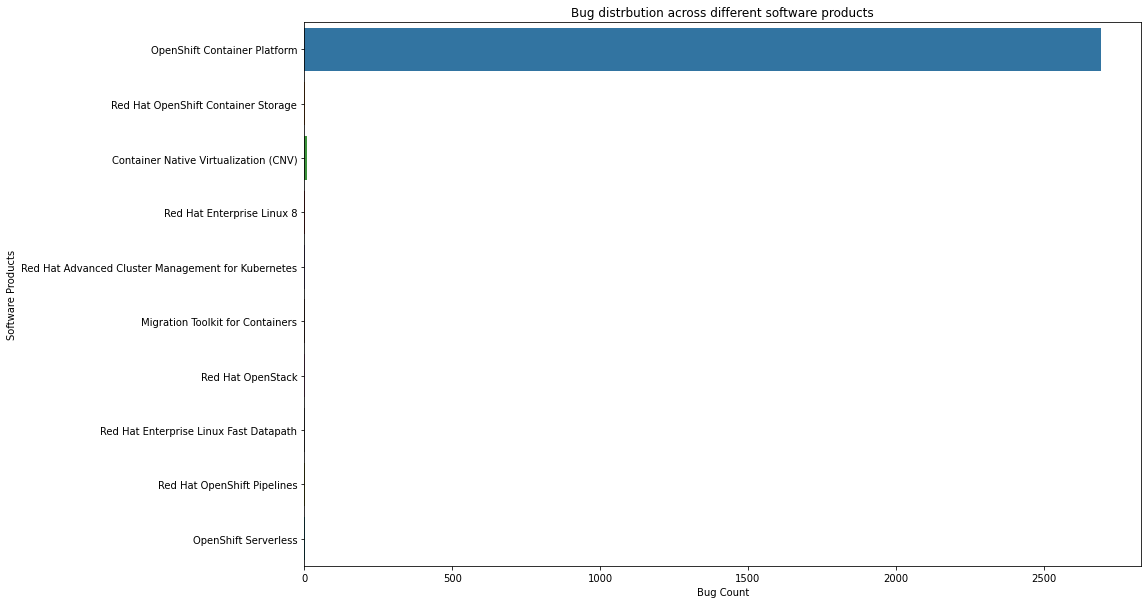

In [61]:
plt.figure(figsize = (15,10))
sns.barplot(product_count, products)
plt.xlabel("Bug Count")
plt.ylabel("Software Products")
plt.title("Bug distrbution across different software products")
plt.show()

### target_milestone

In [62]:
bugs_df.target_milestone.head()

0    ---
1    NaN
2    ---
3    ---
4    ---
Name: target_milestone, dtype: object

In [63]:
bugs_df.target_milestone.unique()

array(['---', nan, 'rc'], dtype=object)

The `target_milestone` is used to define when the engineer the bug is assigned to expects to fix it. However, it doesn't seem to be applicable for most bugs.

### is_confirmed

In [64]:
bugs_df.is_confirmed.head()

0    True
1     NaN
2    True
3    True
4    True
Name: is_confirmed, dtype: object

The `is_confirmed` field seems to return a boolean value (not sure what it indicates) and doesn't seem to be useful for our analysis.

### components

In [65]:
bugs_df.components.head()

0        [Networking]
1                 NaN
2    [kube-scheduler]
3           [Storage]
4     [Documentation]
Name: components, dtype: object

The `components` field returns the same values as the `component` field, but in a list format.

### sub_components

In [66]:
bugs_df.sub_components.head()

0    {'Networking': ['openshift-sdn']}
1                                  NaN
2                                   {}
3                                   {}
4                                   {}
Name: sub_components, dtype: object

The `sub_components` field is similar to the `sub_component` field, but returns both the component and sub-component affected by the bug in a dictionary format.

### versions

In [67]:
bugs_df.versions.head()

0      [4.7]
1        NaN
2      [4.4]
3    [4.3.z]
4    [4.3.0]
Name: versions, dtype: object

The `versions` field returns the same values as the `version` field, but in a list format.

### fixed_in

In [68]:
bugs_df.fixed_in[:15]

0        
1     NaN
2        
3        
4        
5        
6        
7        
8        
9        
10       
11       
12       
13       
14       
Name: fixed_in, dtype: object

In [69]:
bugs_df.fixed_in.unique()

array(['', nan, 'facet-lib v1.4.9', 'OCP-Metal-v1.0.18.1',
       'annair@redhat.com, milei@redhat.com',
       'cri-o-1.20.2, openshift 4.7.4', '2.5.0',
       'runc-1.0.0-82.rhaos4.6.git086e841.el8', 'v0.1.10',
       'OCP-Metal-v1.0.9.5', 'OCP-Metal-v1.0.18.2',
       'podman-1.6.4-11.rhaos4.3.el8', 'OCP-Metal-v1.0.12.1',
       'runc-1.0.0-81.rhaos4.6.git5b757d4',
       'assisted-ui-lib v0.0.13-wizard',
       '4.7.0-0.nightly-2020-12-17-001141',
       'runc-1.0.0-67.rc10.rhaos4.3.el7', '4.8',
       'milei@redhat.com , annair@redhat.com',
       'virt-cdi-importer 2.6.0-15', 'jkaur@redhat.com',
       'OCP-Metal-V1.0.17.3', 'cri-o-1.19.0-62.rhaos4.6.git10c7a86.el8',
       '4.6.4', 'podman-1.9.3-1.rhaos4.6.el8'], dtype=object)

The `fixed_in` field seems to indicate the software version the bug was fixed in. However, it doesn't seem to be applicable to all bugs as some bugs may still be open and not yet resolved.

### weburl

In [70]:
bugs_df.weburl.head()

0    https://bugzilla.redhat.com/show_bug.cgi?id=18...
1                                                  NaN
2    https://bugzilla.redhat.com/show_bug.cgi?id=18...
3    https://bugzilla.redhat.com/show_bug.cgi?id=18...
4    https://bugzilla.redhat.com/show_bug.cgi?id=18...
Name: weburl, dtype: object

In [71]:
bugs_df['bug_id'][0]

1890130

In [72]:
bugs_df['weburl'][0]

'https://bugzilla.redhat.com/show_bug.cgi?id=1890130'

The `weburl` field contains the bugzilla URL for the respective bug ID

## Merge Bug Details + Affected Jobs/Test DF

In [73]:
linked_and_associated_bugs.head()

,dashboard,job,test_name,bug_ids
0,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,"{'name': 'Overall', 'original-name': 'Overall'...",[]
1,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
2,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'Operator results.operator conditions...,[1936859]
3,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]
4,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,[]


In [74]:
firstdf = linked_and_associated_bugs.explode('bug_ids')
firstdf = firstdf.rename(columns={'bug_ids': 'bug_id'})
firstdf.head()

,dashboard,job,test_name,bug_id
0,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,"{'name': 'Overall', 'original-name': 'Overall'...",NaN
1,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,NaN
2,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'Operator results.operator conditions...,1936859
3,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,NaN
4,"""redhat-openshift-ocp-release-4.2-informing""",periodic-ci-openshift-release-master-ci-4.2-e2...,{'name': 'operator.Run multi-stage test e2e-aw...,NaN


In [75]:
res = bugs_df.merge(
    firstdf,
#     how='left',
    left_on='bug_id',
    right_on='bug_id',
)
res.head()

,bug_id,autorefresh,priority,creator,blocks,assigned_to_detail,last_change_time,comments,is_cc_accessible,keywords,...,target_milestone,is_confirmed,components,versions,sub_component,fixed_in,weburl,dashboard,job,test_name
0,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",promote-release-openshift-machine-os-content-e...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
1,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-ocp-installer-e2e-aws-mirror...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
2,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-ocp-installer-e2e-azure-seri...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
3,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-ocp-installer-e2e-gcp-serial...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."
4,1899565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""redhat-openshift-ocp-release-4.2-informing""",release-openshift-origin-installer-e2e-aws-upg...,"{'name': 'Pod', 'original-name': 'Pod', 'alert..."


## Get Linked Bug Data for All Dashboards

In [ ]:
# get all linked bugs
associated_bugs = list()
all_linked_bugs = set()
for dashboard in tqdm(dashboard_names):
    # get all jobs in this dashboard
    response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")
    job_names = response.json().keys()
    
    for job in job_names:
        # get all tests in this job
        response = requests.get(f"https://testgrid.k8s.io/{dashboard}/table?&show-stale-tests=&tab={job}")
        
        # params to send to openshift ci search for tests under this job
        args = {
            'type': 'bug+junit',
            'context': '-1',
            'name': job,
            'maxAge': max_age,
            # DO NOT REMOVE THESE KEYS. THIS HACK PREVENTS REQUESTS FROM TIMING OUT.
            # read more here - https://stackoverflow.com/a/63377265/9743348
            'ajax': 'true',
            'mobile': 'false',
        }
        
        for test in response.json().get('tests', []):
            testname = test['name'].split('.', maxsplit=1)[-1]
            
            # use test name as the search phrase
            args['search'] = testname.replace('[', '\[').replace(']', '\]')

            # search for linked and associated bugs for this test
            response = requests.post(url, data=args)
            soup = BeautifulSoup(response.content)

            # the "em" objects in soup have information that can tell us
            # whether or not this test had a linked bug for the given job name
            em_objects = soup.find_all('em')
            pct_affected = 0
            for em in em_objects:
                if 'Found' in em.text:
                    pct_affected = float(em.text.split()[2][:-1])
                    break

            # init to empty for this test result / reset to empty from previous test result
            test_bugs = []
            
            # if percent jobs affected is 0 then the linked bugs correspond to another job
            if pct_affected > 0:
                result_rows = soup.find('table').find('tbody').find_all('tr')
                for row in result_rows:
                    column_values = row.find_all('td')
                    
                    # if there is only 1 column then the result is a junit, not bug
                    if len(column_values) > 1:
                        # check the second column to make sure it is a bug and not junit details result
                        if column_values[1].text == 'bug':
                            test_bugs.append(column_values[0].text[1:])
                            all_linked_bugs.add(column_values[0].text[1:])

            associated_bugs.append((dashboard, job, test, test_bugs))

## todo

combine it into a dataframe s.t. each row has one bugzilla id, and columns are status, component, etc + affected tests/jobs.